In [75]:
import os, shutil, glob, re
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Convolution2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
import warnings
import random
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [46]:
#Source file 
sourcefile = 'C:/Users/Cuppi/Documents/Unterlagen_CAS_ML/02_Deep_Learning-20210221/Projekt/Test_Datensatz'

In [47]:
phisical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(phisical_devices))
#tf.config.experimental.set_memory_growth(phisical_devices[0], True)

Num GPUs Available:  0


# Data Preparation

In [48]:
#Create subdirectory for each brand

'''
for filename in os.listdir(sourcefile):
    #new_dir = filename.find('_')
    brand = filename.rsplit('_', 17)[0]
    # If folder does not exist try making new one
    try:
        os.mkdir(os.path.join(sourcefile, brand))
    # except error then pass
    except WindowsError:
        pass
    # Move the images from file to new folder based on image name
    shutil.move(os.path.join(sourcefile, filename), os.path.join(sourcefile, brand, filename))
'''

"\nfor filename in os.listdir(sourcefile):\n    #new_dir = filename.find('_')\n    brand = filename.rsplit('_', 17)[0]\n    # If folder does not exist try making new one\n    try:\n        os.mkdir(os.path.join(sourcefile, brand))\n    # except error then pass\n    except WindowsError:\n        pass\n    # Move the images from file to new folder based on image name\n    shutil.move(os.path.join(sourcefile, filename), os.path.join(sourcefile, brand, filename))\n"

In [61]:
#Organize data into train, valid, test dirs
all_subdirs = os.listdir(sourcefile)
len(all_subdirs)

3

In [62]:
for subdirs in all_subdirs:
    os.chdir(sourcefile)
    if os.path.isdir('train/'+subdirs) is False:
        #print(type(str(subdirs+'*')))
        os.makedirs('train/'+subdirs)
        os.makedirs('valid/'+subdirs)
        os.makedirs('test/'+subdirs)
        
        sample_anz = len(os.listdir(sourcefile+'/'+subdirs))
        
        for c in random.sample(glob.glob(str(subdirs+'/'+subdirs+'*')),sample_anz // 10 * 6):
            shutil.copy(c, 'train/'+subdirs)
        for c in random.sample(glob.glob(str(subdirs+'/'+subdirs+'*')),sample_anz // 10 * 2):
            shutil.copy(c, 'valid/'+subdirs)
        for c in random.sample(glob.glob(str(subdirs+'/'+subdirs+'*')),sample_anz // 10 * 2):
            shutil.copy(c, 'test/'+subdirs)
#os.chdir('../../')

In [63]:
train_path = sourcefile+'/train'
valid_path = sourcefile+'/valid'
test_path = sourcefile+'/test'

In [64]:
train_path

'C:/Users/Cuppi/Documents/Unterlagen_CAS_ML/02_Deep_Learning-20210221/Projekt/Test_Datensatz/train'

In [65]:
train_batches = ImageDataGenerator(rescale=1./255, preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=train_path, target_size=(224,224), classes=all_subdirs, batch_size=10)
valid_batches = ImageDataGenerator(rescale=1./255, preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=valid_path, target_size=(224,224), classes=all_subdirs, batch_size=10)
test_batches = ImageDataGenerator(rescale=1./255, preprocessing_function=tf.keras.applications.vgg16.preprocess_input).flow_from_directory(directory=test_path, target_size=(224,224), classes=all_subdirs, batch_size=10, shuffle=False)

Found 246 images belonging to 3 classes.
Found 82 images belonging to 3 classes.
Found 82 images belonging to 3 classes.


In [66]:
type(train_batches)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [67]:
#assert train_batches.n == 1000
#assert valid_batches.n == 200
#assert train_batches.n == 100
assert train_batches.num_classes == valid_batches.num_classes == train_batches.num_classes == 3

In [68]:
imgs, labels = next(train_batches)

In [69]:
#This function will plot images in the form of a grid with 1 row and 10 columns where images are placed
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

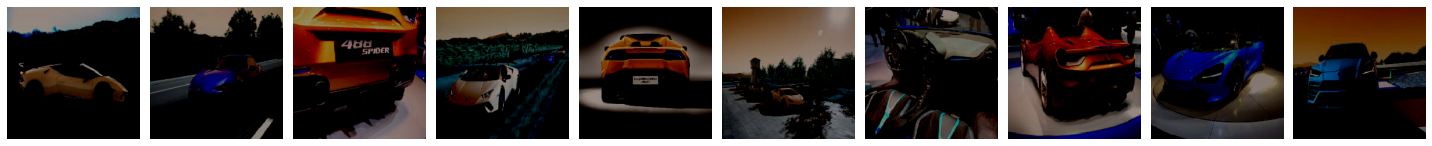

[[0. 1. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 1. 0.]]


In [70]:
plot_images(imgs)
print(labels)

# Model preparation

In [71]:
# here we define hyperparameter of the CNN
batch_size = 10
nb_classes = 3
img_rows, img_cols = 224, 224
kernel_size = (3, 3)
input_shape = (img_rows, img_cols, 3)
pool_size = (2, 2)

In [76]:
# define CNN with 2 convolution blocks and 2 fully connected layers
model = Sequential()

model.add(Convolution2D(8,kernel_size,padding='same',input_shape=input_shape))
model.add(Activation('relu'))
model.add(Convolution2D(8, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Convolution2D(16, kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(Convolution2D(16,kernel_size,padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))

model.add(Flatten())
model.add(Dense(40))
model.add(Activation('relu'))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# compile model and intitialize weights
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


# summarize model along with number of model weights
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 8)       224       
_________________________________________________________________
activation_2 (Activation)    (None, 224, 224, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 224, 224, 8)       584       
_________________________________________________________________
activation_3 (Activation)    (None, 224, 224, 8)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
activation_4 (Activation)    (None, 112, 112, 16)     

In [77]:
# train the model
history=model.fit(train_batches, 
                  batch_size=10, 
                  epochs=10,
                  verbose=1, 
                  validation_data=(valid_batches)
                 )

Epoch 1/10
25/25 [==============================] - 31s 1s/step - loss: 1.1779 - accuracy: 0.5196 - val_loss: 0.7613 - val_accuracy: 0.6829
Epoch 2/10
25/25 [==============================] - 23s 900ms/step - loss: 0.6649 - accuracy: 0.7194 - val_loss: 0.6371 - val_accuracy: 0.7317
Epoch 3/10
25/25 [==============================] - 22s 847ms/step - loss: 0.5283 - accuracy: 0.7618 - val_loss: 0.4583 - val_accuracy: 0.8415
Epoch 4/10
25/25 [==============================] - 23s 914ms/step - loss: 0.2959 - accuracy: 0.8865 - val_loss: 0.3557 - val_accuracy: 0.9024
Epoch 5/10
25/25 [==============================] - 22s 860ms/step - loss: 0.0545 - accuracy: 0.9979 - val_loss: 0.4267 - val_accuracy: 0.8780
Epoch 6/10
25/25 [==============================] - 25s 990ms/step - loss: 0.0125 - accuracy: 1.0000 - val_loss: 0.5581 - val_accuracy: 0.8780
Epoch 7/10
25/25 [==============================] - 27s 1s/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.5369 - val_accuracy: 0.8902
Epoch

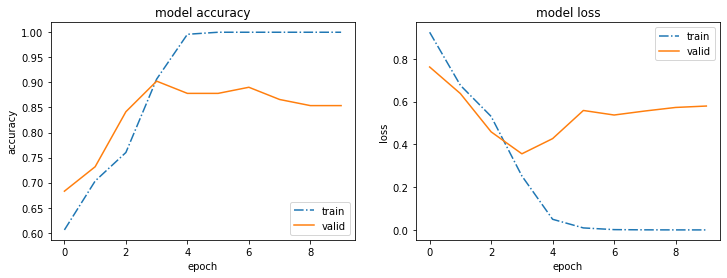

In [78]:
# plot the development of the accuracy and loss during training
plt.figure(figsize=(12,4))
plt.subplot(1,2,(1))
plt.plot(history.history['accuracy'],linestyle='-.')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='lower right')
plt.subplot(1,2,(2))
plt.plot(history.history['loss'],linestyle='-.')
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')